In [27]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from tqdm import tqdm

In [2]:
ds_p = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-precipitation_ymon.nc")

In [3]:
ds_t_avg = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-temperature-ymon.nc")

In [4]:
ds_t_std = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-t2m_ymonstd.nc")

In [5]:
lons, lats = np.meshgrid(ds_p.lon, ds_p.lat)

In [6]:
ds_pine = xr.open_dataset('../../data/sweden/mescan-surfex_pine.nc')

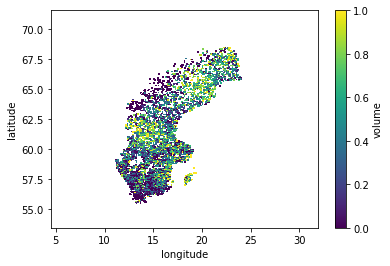

In [7]:
ds_pine.volume.plot()

In [8]:
data = {
    'ratio': ds_pine.volume.values.ravel()
}

In [9]:
for m in range(0, 12):
    data["p%02d" % (m + 1)] = ds_p.tp[m,:,:].values.ravel()
    data["tavg%02d" % (m + 1)] = ds_t_avg['2t'][m,:,:].values.ravel()
    data["tstd%02d" % (m + 1)] = ds_t_std['2t'][m,:,:].values.ravel()

In [10]:
df = pd.DataFrame(data)

In [11]:
df.dropna(inplace=True)

In [12]:
df['predominant'] = np.where(df['ratio'] > 0.5, 1, 0)

In [13]:
df.head()

,ratio,p01,tavg01,tstd01,p02,tavg02,tstd02,p03,tavg03,tstd03,...,p10,tavg10,tstd10,p11,tavg11,tstd11,p12,tavg12,tstd12,predominant
20610,0.956418,429.878784,-3.159124,8.977105,315.316345,-3.058709,9.162731,320.702026,0.008770,8.366390,...,659.974915,7.199598,7.973645,586.692322,3.109512,7.838320,418.880554,-1.011361,8.407584,1
20611,0.934010,442.777954,-3.200053,8.968402,325.709259,-3.134155,9.165648,326.748535,-0.050659,8.353924,...,685.620667,7.169259,7.936562,606.884094,3.074059,7.828258,426.410522,-1.057354,8.404086,1
20618,0.984500,538.552612,-3.451118,8.970026,418.236633,-3.414907,9.228292,394.337036,-0.139035,8.284694,...,848.545593,7.014369,7.894584,729.001770,2.832583,7.810921,608.028076,-1.313700,8.407911,1
20941,0.000000,449.715546,-3.239600,8.901311,325.663422,-3.227357,9.143815,315.328247,-0.146665,8.336580,...,692.830200,7.089822,7.887585,613.881042,2.980710,7.797534,420.654572,-1.126507,8.361822,0
20942,0.445305,463.252899,-3.333051,8.917417,325.359863,-3.325634,9.174139,312.334717,-0.218715,8.349739,...,693.957581,7.035167,7.874893,620.472229,2.913463,7.800209,424.497833,-1.212814,8.375235,0


In [14]:
df.columns[1:-2]

Index(['p01', 'tavg01', 'tstd01', 'p02', 'tavg02', 'tstd02', 'p03', 'tavg03',
       'tstd03', 'p04', 'tavg04', 'tstd04', 'p05', 'tavg05', 'tstd05', 'p06',
       'tavg06', 'tstd06', 'p07', 'tavg07', 'tstd07', 'p08', 'tavg08',
       'tstd08', 'p09', 'tavg09', 'tstd09', 'p10', 'tavg10', 'tstd10', 'p11',
       'tavg11', 'tstd11', 'p12', 'tavg12'],
      dtype='object')

In [15]:
X = df[df.columns[1:-1]]

In [16]:
y = df["predominant"]

In [17]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

In [19]:
rf = RandomForestClassifier(n_estimators=500, max_depth=15)

In [20]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
y_pred = rf.predict(X_test)

In [22]:
precision_score(y_test, y_pred)

0.7226993865030675

In [23]:
accuracy_score(y_test, y_pred)

0.7085967130214917

In [24]:
recall_score(y_test, y_pred)

0.7148058252427184

In [25]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[532, 226],
       [235, 589]])

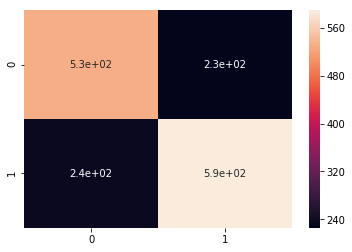

In [28]:
sn.heatmap(cm, annot=True)

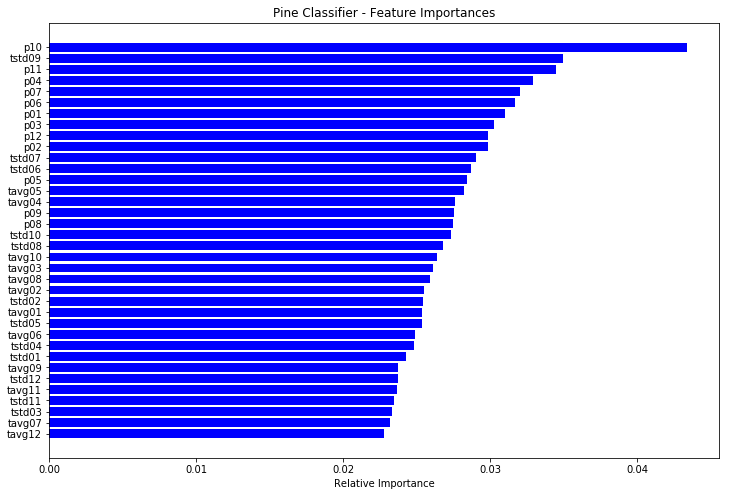

In [30]:
features = [c for c in X.columns]
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Pine Classifier - Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()